<h1 style="text-align:center">Simple Pendulum Example</h1>
<h3 style="text-align:center">MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

In this example, we'll determine the equations of motion for the simple pendulum system shown in Figure 1. The system consists of a point mass, $m$, connected to an ideal pin by a massless rod of length $l$. The rotation of the pendulum is represented by $\theta$.

<p style="text-align:center">
	<img src="http://shared.crawlab.org/Pendulum_simple.png" alt="Simple Pendulum" width=15%><br>
    <strong>Figure 1: Simple Pendulum</strong>
</p>

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import LagrangesMethod
from sympy.physics.mechanics import Particle, Point, ReferenceFrame

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Define the genearlized coordinate
theta = dynamicsymbols('theta')

# Also define the first derivative
theta_dot = dynamicsymbols('theta', 1)

# Define the symbols for the other paramters
m, g, l, f = sympy.symbols('m, g, l, f')

In [3]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the pendulum, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [theta, N.z])

# Define the points and set its velocity
P = Point('P')
P.set_vel(N, l * theta_dot * A.x)

mp = Particle('mp', P, m)

# Set up the force list - each item follows the form:
#    (the location where the force is applied, its magnitude and direction)
# Here, there are no non-conservataive external forces
forces = []

# Form the Lagrangian - L = T - V
L = (1 / 2 * m * l**2 * theta_dot**2) + (m * g * l * sympy.cos(theta))

In [4]:
# This creates a LagrangesMethod class instance that will allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [theta], forcelist = forces, frame = N)

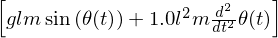

In [5]:
LM.form_lagranges_equations()

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.

In [6]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

In [7]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the sytsem as a set of first order ODEs, suitable for simluation.

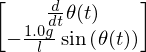

In [8]:
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

We can also linearize these equations with builtin SymPy methods. Let's do so about the $\theta = 0$, $\dot{\theta} = 0$ operating point. The resulting equations returned are a system of first order ODEs in state-space form:

$$ \dot{x} = Ax + Bu $$

See the [SymPy Documentation](http://docs.sympy.org/0.7.6/modules/physics/mechanics/linearize.html#linearizing-lagrange-s-equations) for much more information.

In [9]:
# Define the point to linearize around
operating_point = {theta: 0.0, theta_dot: 0.0}

# Make the call to the linearizer
A, B, inp_vec = LM.linearize([theta], [theta_dot],
                             op_point = operating_point, 
                             A_and_B = True)

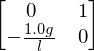

In [10]:
A

In [11]:
B

The $B$ matrix is empty, as we expect, since there are have no external non-conservative forces.

Given these two matrices, the system of equations match those that we'd expect:

$$ \begin{bmatrix}\dot{w}_1 \\ \dot{w}_2\end{bmatrix} = \begin{bmatrix}0 & 1 \\ -\frac{g}{l} & 0 \end{bmatrix} \begin{bmatrix}w_1 \\ w_2\end{bmatrix}$$

where:

$$ \mathbf{w} = \begin{bmatrix}w_1 \\ w_2\end{bmatrix} = \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix} $$

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [12]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(codecs.open(css_file, 'r', 'utf-8').read())